# DTEK0042 Exercise 4
    Group Members:
    1. Ayesha Zafar
    2. Mishqat Maqbool
    3. Rimsha Koakab

*** Note for Google Colab Users ***
     Because Google Colab doesn't have a button to convert your notebook to .html format here is a quick work around:
   1. open a new google colab notebook
   2. in the files section in google colab, upload the .ipynb file you want to be converted to .html
   3. in your new open notebook run this command in an empty cell: !jupyter nbconvert --to html YourFileName.ipynb
   4. after the command is finished running refresh the page
   5. In your files section you should see your original .ipynb file that you uploaded and then a .html file of that same notebook.
   6. download the .html file and you're good to go!

In this exercise, you are required to analyze a SCG signal step-by-step as outlined below.  The deliverables for this exercise are a jupyter notebook and a .html file exported form the notebook. The notebook should includes your code, observations, graphs, and conclusions made upon analyzing the given SCG signals. Please provide caption and description for every figure. 

## 1- library Imports

In [5]:
from scipy import signal,stats
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn import preprocessing as prep
from glob import glob
import os

# Data Import 
* Load the .txt files of SCG data that are stored in the folder named “dataset” into your python environment.  
* For each .txt data file, select the 3rd column which contains the Z-axis of the SCG signals. 
* Note: the sampling frequency of this signal is 200 Hz. 

        Hint:  
        * to automate the loading process you can get a list of all data file paths using glob package and subsequently load the files in a for loop. 
        
        * dataFiles = glob.glob(path_to_dataset) to get a list of file paths of "dataset\xxdata.txt"
        
         then load the paths one by one in a loop

In [7]:
fs=200 #samp freq

# Path to data files
data_path = "dataset" 
data_files = glob(os.path.join(data_path, "*.txt"))

noisy_data = []
normal_data = []

# Loading and separating files based on filename pattern
for file in data_files:
    data = np.loadtxt(file)
    # Getting third column (Z-axis of SCG signal)
    z_axis = data[:, 2] 

    # Separating into noisy or normal based on file name
    if "Noisy" in file:
        noisy_data.append(z_axis)
    elif "Normal" in file:
        normal_data.append(z_axis)


# Noisy Vs Normal Plotting

* Plot the z-axis SCG signal from the file "Noisy_data_1.txt" and plot the z-axis SCG signal from the file "Normal_data_1.txt" 
* Describe your observations and how the plots differ from one another.


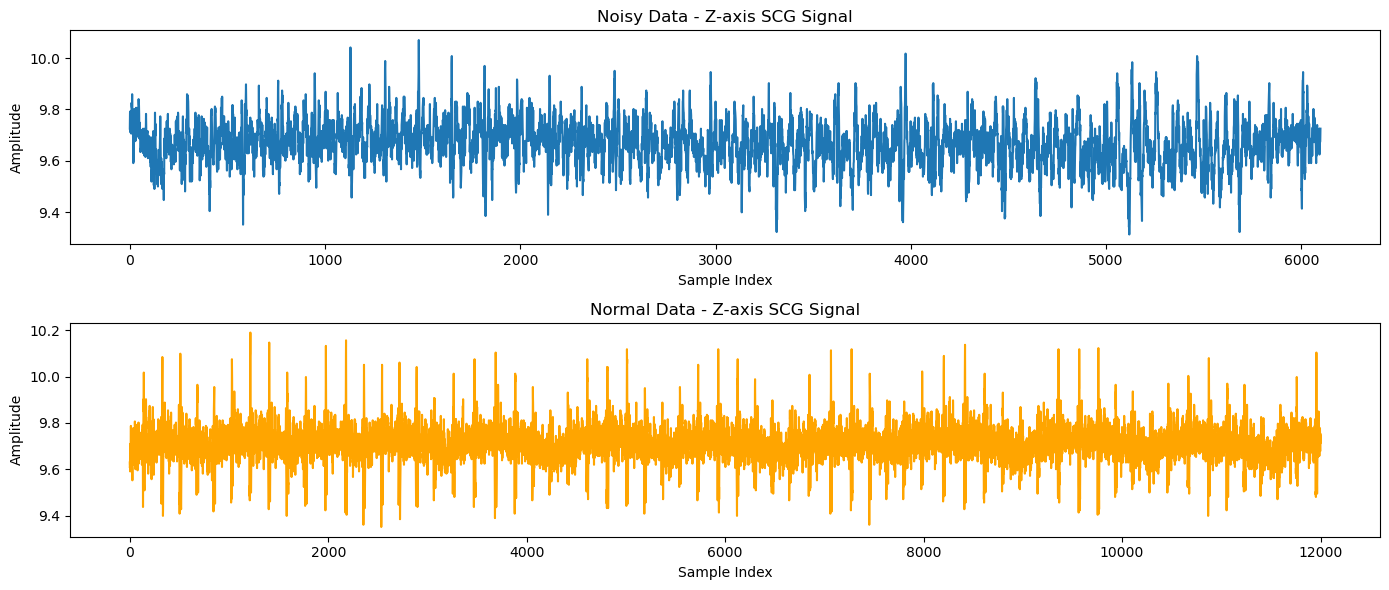

In [9]:
# Ploting z-axis SCG signal for required files
plt.figure(figsize=(14, 6))

# Noisy data
plt.subplot(2, 1, 1)
plt.plot(noisy_data[0])
plt.title("Noisy Data - Z-axis SCG Signal")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")

# Normal data
plt.subplot(2, 1, 2)
plt.plot(normal_data[0], color='orange')
plt.title("Normal Data - Z-axis SCG Signal")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")

plt.tight_layout()
plt.show()


## Observations:

- The Noisy Data shows high-frequency fluctuations, while the Normal Data has clearer, periodic peaks and less noise.

- Noisy data ranges roughly from 9.4 to 10, while normal data spans a slightly larger range, around 9.4 to 10.2, with structured peaks.

- Normal data shows clear periodic patterns, likely representing physiological events. The noisy data appears random and lacks structure.

- Noisy data has fewer samples (~6000) compared to normal data (~12000), indicating a shorter recording period.

# Data Segmentation 
* Here is a simple function to use for data segmentation
* Segment the Z-axis signals into 5-second segments
* The sampling frequency used to record these signals is 200 Hz.
* Store the segments and the accompanying labels

In [12]:
# #code (provided)

def _slicing(sig, file_label, segment_length = 1000):
    
    """
    inputs:
    sig : input array to be segmented
    file_label : label to be applied to segmented signal
    segment_length : Length in samples of the segments produced from the input signal
    
    outputs:
    sig_sliced : a list of segments
    label : a list of corresponding labels for the segmented signal 
    
    """

    sig_sliced = []
    label = []
    
    # slicing 
    
    for i in np.arange(int(len(sig)/segment_length)):

        sig_sliced.append( sig[i*segment_length:(i+1)*segment_length] )

        label.append(file_label)
        
    return (sig_sliced , label)


# Segmenting noisy and normal data
noisy_segments = []
noisy_labels = []
normal_segments = []
normal_labels = []

for z_axis in noisy_data:
    segments, labels = _slicing(z_axis, "noisy")
    noisy_segments.extend(segments)
    noisy_labels.extend(labels)

for z_axis in normal_data:
    segments, labels = _slicing(z_axis, "normal")
    normal_segments.extend(segments)
    normal_labels.extend(labels)


# Feature Extraction Function Creation
*  Define a function and name it “feature_extraction” in which you compute and return the features listed below
    * *Time Domain Features*:  mean, standard deviation, interquartile-range, median, peak-to-peak range, skewness, kurtosis, and root mean square. 
    * *Frequency Domain Features*: power spectral density (using welch function of scipy)
    
        * For power spectral density, Calculate the total power spectral density within frequency bins of 4 Hz steps. Discard the frequencies above 40 Hz. Get the power within each bin.
    
        Hint:
        
        Reference: https://docs.scipy.org/doc/scipy/reference/stats.html for skewness, kurtosis, interquartile-range(iqr)
        
        Reference: https://numpy.org/doc/stable/reference/routines.statistics.html for other time domain features
        
        Reference: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.scale.html for transforming to zero mean and unit variance



In [14]:
# #code
def feature_extraction(sig, fs=200):
    """
    inputs:
    sig : input array to extract features from
    fs : sampling frequency of input array

    outputs:
    feature_array: an array containing all the features extracted from the signal 
    """
    # Time-domain features
    mean_val = np.mean(sig)
    std_val = np.std(sig)
    iqr_val = stats.iqr(sig)
    median_val = np.median(sig)
    ptp_val = np.ptp(sig)
    skewness = stats.skew(sig)
    kurtosis = stats.kurtosis(sig)
    rms_val = np.sqrt(np.mean(sig**2))

    # Frequency-domain features 
    transformed_sig = prep.scale(sig)  
    frequencies, psd = signal.welch(transformed_sig, fs=fs)

    # PSD in 4 Hz bins up to 40 Hz
    freqs_arr = np.arange(0, 41, 4)
    psd_binned_sum = []
    for i in range(len(freqs_arr) - 1):
        psd_binned_sum.append(np.sum(psd[(frequencies >= freqs_arr[i]) & (frequencies < freqs_arr[i + 1])]))

    # Combining all features into a single feature array
    feature_array = [mean_val, std_val, iqr_val, median_val, ptp_val, skewness, kurtosis, rms_val] + psd_binned_sum
    return feature_array


# Feature Extraction Application

* You must first segment your signals and then extract features from each segment. You could do it in the following way:



* Call the _slicing function to section all the z-axis data into 5-second segments
        Hint: Load each file in "dataFiles" with for-loop
* Use the feature extraction function you created and extract features from every segment that you have obtained.
* Store the labels and the features you extracted from each segment to numpy arrays. 
        Hint: Think of an easy way to extract the label "noisy" or "normal" from each file name
        str.split() could be used somehow in this case

In [16]:
features = []
labels = []

# Applying feature extraction on each noisy segment
for segment in noisy_segments:
    features.append(feature_extraction(segment))
    labels.append("noisy")

# Applying feature extraction on each normal segment
for segment in normal_segments:
    features.append(feature_extraction(segment))
    labels.append("normal")

# Converting to numpy arrays
features = np.array(features)
labels = np.array(labels)


# Standardize Features
Hint:

    Use sklearn.preprocessing.scale() to standardize the features
    Reference: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.scale.html

In [18]:
features_standardized = prep.scale(features)

# Principal Component Analysis
* Principal Component Analysis (PCA) is used to reduce the dimensionality of a data set consisting of many variables correlated with each other. This can then be used to visualize the data in a more practical way. 
* Compute the first and 2nd principal components
* Plot the two components on a scatter plot with the coloring done by label
* Are these features useful to seperate the two types of signals (noisy vs normal)?
* Describe your observations.
    
        Hint:
        my_pca=PCA(n_components=2)
        pca_out = my_pca.fit_transform(input)

In [20]:
# Applying PCA to reduce to 2 components
pca = PCA(n_components=2)
pca_result = pca.fit_transform(features_standardized)


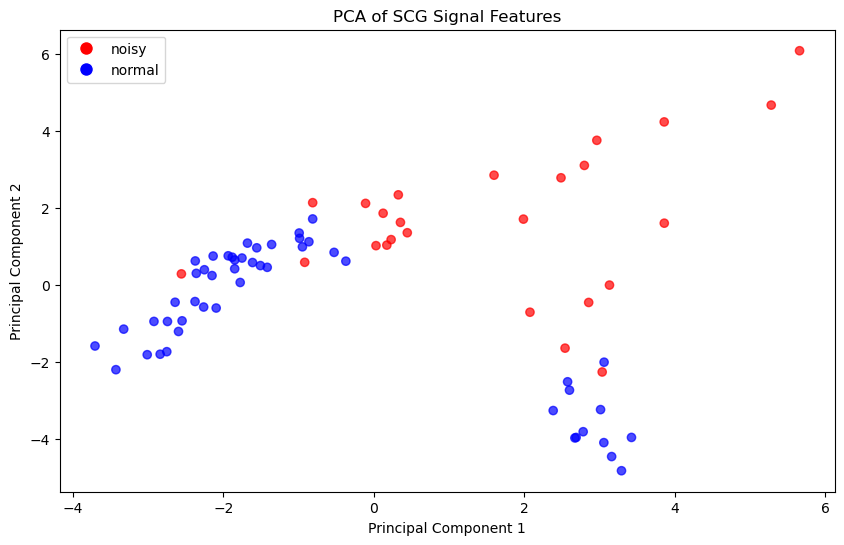

In [21]:
# Converting labels to colors for visualization
color_map = {'noisy': 'red', 'normal': 'blue'}
colors = [color_map[label] for label in labels]

# Ploting PCA results
plt.figure(figsize=(10, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=colors, alpha=0.7)
plt.title("PCA of SCG Signal Features")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(handles=[plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=label) 
                    for label, color in color_map.items()])
plt.show()


## Observations 

- The noisy and normal data points are well-separated in the PCA plot, indicating that the features extracted successfully distinguish between noisy and normal signals.

- The noisy data forms several clusters on the right, suggesting varied noise characteristics. In contrast, normal data clusters more tightly on the left, reflecting consistent, stable patterns in the normal signal.

- Separation mainly occurs along Principal Component 1, showing it captures most of the variance related to noise versus normal distinction, while Principal Component 2 has less impact on class separation.

- Some overlap near the center suggests a few noisy segments resemble normal data, possibly due to mild noise that doesn’t significantly affect the signal's main features.